## ANALYSIS REPORT TO MANAGEMENT

**Made by**: Cihat Burak Zorlu, MSBA-2 
**Date**: 28 January 2021

### Introduction

   In this project I was given the task to identify what effects the Revenue and the Cross Selling success for the Apprentice Chef. Apprentice Chef is a company which delivers food to professional who has limited time to cook. 
   More specifically, what features effects the success of both individually.

### Analysis of Models   
   To begin with, I have done my regression model on the Revenue as my response variable. I have Future engineered some features. I have separated the email domain groups and tried to understand what might affect the revenue other the features which were given. Total meals ordered (0.6) and the Average clicks per visit (-0.55) features have the most impact on the revenue with highest **R-Squared** of 0.642. After I have done some logarithmic transformations, some variables become more noticeable. My **OLS** model had 0.7182 Training, 0.7179 Testing Score and with gap of 0.0003. Model's performance is very good due to small gap. 
    Total meals ordered, average preparation video time, and median meal rating have highly impacted the revenue generation. 
	Later on, with Cross Sell Success, I have distinguished each domain name and length of names as my future engineering for this feature. Length of names has a huge impact on the cross-sell success because if people are more willing to write their name longer, they are more likely to buy product or the service. My Tuned Tree model came out to be the best model with **AUC** score of 0.717 and has the lowest False Positive value. False positive value was one of the key metrics for this model and keeping that lower was one of the key challenges. 

### Recommendations

-Decrease steps until checkout, increase in number of clicks decreases revenue. 

-Attract people who are not professionals, because personal domains have high significance in cross sell success.

-Upload more meal preparation videos and promote videos more to increase cross sell success.

-Make more promotions to people who have rated meals over average. 

-Upload more images/pictures of meals because they promote success revenue wise. 


In [10]:
import random            as rand                     # random number gen
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
import numpy as np
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression, LinearRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

In [2]:
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
file = "./Apprentice_Chef_Dataset.xlsx"

In [3]:
df_chef = pd.read_excel(file)

In [4]:
continuous_data = ["REVENUE",  "TOTAL_MEALS_ORDERED", 
                    "UNIQUE_MEALS_PURCH", "CONTACTS_W_CUSTOMER_SERVICE",  
                    "AVG_CLICKS_PER_VISIT", "TOTAL_PHOTOS_VIEWED" ]

chef_corr = df_chef[continuous_data].corr("pearson")
chef_corr.loc[ : , "REVENUE"].round(decimals = 2).sort_values(ascending = False)

REVENUE                        1.00
TOTAL_MEALS_ORDERED            0.60
TOTAL_PHOTOS_VIEWED            0.47
CONTACTS_W_CUSTOMER_SERVICE    0.10
UNIQUE_MEALS_PURCH            -0.06
AVG_CLICKS_PER_VISIT          -0.55
Name: REVENUE, dtype: float64

In [5]:
# log transforming REVENUE and saving it to the dataset as log_REVENUE
# since our Y- variable is skewed, we want to normalize it as much as we can 
#we transform it into logarithmic form 
#while transforming some Y variables which are also skewed
df_chef['log_REVENUE'] = np.log10(df_chef['REVENUE'])
df_chef['log_TOTAL_MEALS_ORDERED'] = np.log10(df_chef['TOTAL_MEALS_ORDERED'])
df_chef['log_MEDIAN_MEAL_RATING'] = np.log10(df_chef['MEDIAN_MEAL_RATING'])
df_chef['log_CONTACTS_W_CUSTOMER_SERVICE'] = np.log10(df_chef['CONTACTS_W_CUSTOMER_SERVICE'])
df_chef['log_AVG_PREP_VID_TIME'] = np.log10(df_chef['AVG_PREP_VID_TIME'])
df_chef['log_UNIQUE_MEALS_PURCH'] = np.log10(df_chef['UNIQUE_MEALS_PURCH'])

In [6]:
# placeholder list to store the emails 
placeholder_lst = []

# looping over each email address
for index, col in df_chef.iterrows():
    
    # splitting email domain at '@'
    split_email = df_chef.loc[index, 'EMAIL'].split(sep = "@")
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
df_chef_email = pd.DataFrame(placeholder_lst)
# displaying the results
df_chef["EMAIL_DOMAIN"] = df_chef_email[1]

In [7]:
EMAIL_DUMMIES = pd.get_dummies(df_chef["EMAIL_DOMAIN"])
df_chef = df_chef.drop("EMAIL_DOMAIN", axis = 1)
df_chef = df_chef.join([EMAIL_DUMMIES])

In [42]:
lm_log = smf.ols(formula = """log_REVENUE ~ TOTAL_MEALS_ORDERED +
                    CONTACTS_W_CUSTOMER_SERVICE + AVG_PREP_VID_TIME + 
                    TOTAL_PHOTOS_VIEWED + MEDIAN_MEAL_RATING + MASTER_CLASSES_ATTENDED + 
                    LARGEST_ORDER_SIZE + AVG_TIME_PER_SITE_VISIT""", 
              data = df_chef)
results_lm_log= lm_log.fit()
print(results_lm_log.summary())

                            OLS Regression Results                            
Dep. Variable:            log_REVENUE   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     437.6
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:51:42   Log-Likelihood:                 1264.0
No. Observations:                1946   AIC:                            -2510.
Df Residuals:                    1937   BIC:                            -2460.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [8]:
# Preparing my data for train&test split
x_variables = ['log_TOTAL_MEALS_ORDERED', 'log_CONTACTS_W_CUSTOMER_SERVICE', 'log_AVG_PREP_VID_TIME', 
               'TOTAL_PHOTOS_VIEWED', 'log_MEDIAN_MEAL_RATING', 'MASTER_CLASSES_ATTENDED', 'log_UNIQUE_MEALS_PURCH',
               'LARGEST_ORDER_SIZE', 'AVG_TIME_PER_SITE_VISIT', 'visa.com', 'microsoft.com', 
              'intel.com', 'hotmail.com', 'exxon.com', 'cocacola.com', ] # for OLS

df_chef_ols = df_chef[x_variables] # explanatory variable data for OLS

df_chef_1 = df_chef.drop(['REVENUE', 'NAME', 'EMAIL', 
                     'FIRST_NAME', 'FAMILY_NAME', 'log_REVENUE'], axis = 1) # explanatory variable data for others

df_chef_target_1 = df_chef.loc[ : , 'log_REVENUE'] # response variable
df_chef_target = df_chef.loc[ : , 'REVENUE']

x_train_OLS, x_test_OLS, y_train_OLS, y_test_OLS = train_test_split(
            df_chef_ols,
            df_chef_target_1,
            test_size = 0.25,
            random_state = 219)

print(f"""
OLS Training Data
-----------------
X-side: {x_train_OLS.shape}
y-side: {y_train_OLS.shape}

OLS Testing Data
----------------
X-side: {x_test_OLS.shape}
y-side: {y_test_OLS.shape}
""")

x_train, x_test, y_train, y_test = train_test_split(
            df_chef_1,
            df_chef_target,
            test_size = 0.25,
            random_state = 219)

print(f"""
Training Data
-------------
X-side: {x_train.shape}
y-side: {y_train.shape}

Testing Data
------------
X-side: {x_test.shape}
y-side: {y_test.shape}
""")


OLS Training Data
-----------------
X-side: (1459, 15)
y-side: (1459,)

OLS Testing Data
----------------
X-side: (487, 15)
y-side: (487,)


Training Data
-------------
X-side: (1459, 67)
y-side: (1459,)

Testing Data
------------
X-side: (487, 67)
y-side: (487,)



In [11]:
# INSTANTIATING a model object
lr = LinearRegression()


# FITTING to the training data
lr_fit = lr.fit(x_train_OLS, y_train_OLS)


# PREDICTING on new data
lr_pred = lr_fit.predict(x_test_OLS)


# SCORING the results
print('OLS Training Score :', lr.score(x_train_OLS, y_train_OLS).round(4))  # using R-square
print('OLS Testing Score  :',  lr.score(x_test_OLS, y_test_OLS).round(4)) # using R-square

OLS_train_score = lr.score(x_train_OLS, y_train_OLS).round(4)
OLS_test_score = lr.score(x_test_OLS, y_test_OLS).round(4)

# displaying and saving the gap between training and testing
print('Linear Train-Test Gap :', abs(OLS_train_score - OLS_test_score).round(4))
OLS_test_gap = abs(OLS_train_score - OLS_test_score).round(4)

OLS Training Score : 0.7182
OLS Testing Score  : 0.7179
Linear Train-Test Gap : 0.0003


In [12]:
lr_model_values = zip(df_chef_1[x_variables].columns,
                      lr_fit.coef_.round(decimals = 2))
# setting up a placeholder list to store model features
lr_model_lst = [('intercept', lr_fit.intercept_.round(decimals = 2))]
# printing out each feature-coefficient pair one by one
for val in lr_model_values:
    lr_model_lst.append(val)
# checking the results
for pair in lr_model_lst:
    print(pair)

('intercept', 1.48)
('log_TOTAL_MEALS_ORDERED', 0.26)
('log_CONTACTS_W_CUSTOMER_SERVICE', 0.13)
('log_AVG_PREP_VID_TIME', 0.57)
('TOTAL_PHOTOS_VIEWED', 0.0)
('log_MEDIAN_MEAL_RATING', 0.32)
('MASTER_CLASSES_ATTENDED', 0.03)
('log_UNIQUE_MEALS_PURCH', -0.17)
('LARGEST_ORDER_SIZE', -0.01)
('AVG_TIME_PER_SITE_VISIT', -0.0)
('visa.com', 0.0)
('microsoft.com', -0.04)
('intel.com', -0.0)
('hotmail.com', -0.02)
('exxon.com', 0.02)
('cocacola.com', 0.01)


In [13]:
professional = ["mmm.com", "amex.com", "apple.com", "boeing.com", "caterpillar.com",
    "chevron.com", "cisco.com", "cocacola.com", "disney.com", "dupont.com",
    "exxon.com", "ge.org", "goldmansacs.com", "homedepot.com", "ibm.com",
    "intel.com", "jnj.com", "jpmorgan.com", "mcdonalds.com", "merck.com",
    "microsoft.com", "nike.com", "pfizer.com", "pg.com", "travelers.com",
    "unitedtech.com", "unitedhealth.com", "verizon.com", "visa.com",
    "walmart.com"]

personal = ["gmail.com", "yahoo.com", "protonmail.com"]

junk = ["me.com", "aol.com", "hotmail.com", "live.com", "msn.com", "passport.com"]

# Split by @ and select domains
df_chef['EMAIL_DOMAIN'] = df_chef.EMAIL.str.split('@', expand=True)[1]

# Create email_tue column
df_chef['EMAIL_TYPE'] = '0'

# Populate the Email Type column by if else statements
for index, row in df_chef.iterrows():

    if df_chef.loc[index, 'EMAIL_DOMAIN'] in professional:
        df_chef.loc[index, 'EMAIL_TYPE'] = 'professional'
    elif df_chef.loc[index, 'EMAIL_DOMAIN'] in personal:
        df_chef.loc[index, 'EMAIL_TYPE'] = 'personal'
    elif df_chef.loc[index, 'EMAIL_DOMAIN'] in junk:
        df_chef.loc[index, 'EMAIL_TYPE'] = 'junk'
    elif df_chef.loc[index, 'EMAIL_DOMAIN'] not in professional or df_chef.loc[
            row, 'EMAIL'] not in personal or df.loc[row, 'EMAIL'] not in junk:
        df_chef.loc[index, 'EMAIL_TYPE'] = 'unknown'
    else:
        print("NOT VALID")

email_dummies = pd.get_dummies(df_chef.EMAIL_TYPE, drop_first=True)

df_chef = pd.concat([df_chef, email_dummies], axis=1)

In [15]:
char = df_chef.loc[:, "NAME"]
df_chef["NUMBER_LETTERS"]  = [len(i) for i in char]

In [16]:
chef_data = df_chef.drop(["CROSS_SELL_SUCCESS", 'log_TOTAL_MEALS_ORDERED', 'log_CONTACTS_W_CUSTOMER_SERVICE', 'log_AVG_PREP_VID_TIME', 
             'log_MEDIAN_MEAL_RATING','log_UNIQUE_MEALS_PURCH'], axis = 1)
chef_target = df_chef.loc[:, "CROSS_SELL_SUCCESS"]

In [17]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            chef_data,
            chef_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = chef_target)


# merging training data for statsmodels
chef_train = pd.concat([x_train, y_train], axis = 1)

In [26]:

candidate_dict = {
 'logit_full'   : [ "professional" ,
"CANCELLATIONS_BEFORE_NOON"      ,
"MOBILE_NUMBER"                  ,
"TASTES_AND_PREFERENCES"         ,
"REFRIGERATED_LOCKER"            ,
"MASTER_CLASSES_ATTENDED"        ,
"PACKAGE_LOCKER"                 ,
"CONTACTS_W_CUSTOMER_SERVICE"    ,
"personal"                       ,
"PC_LOGINS"                      ,
"MEDIAN_MEAL_RATING"             ,
"AVG_PREP_VID_TIME"              ,
"LARGEST_ORDER_SIZE"             ,
"EARLY_DELIVERIES"               ,
"LATE_DELIVERIES"                ,
"TOTAL_MEALS_ORDERED"            ,
"TOTAL_PHOTOS_VIEWED"            ,
"AVG_TIME_PER_SITE_VISIT"        ,
"UNIQUE_MEALS_PURCH"             ,
"REVENUE"                        ,
"PRODUCT_CATEGORIES_VIEWED"      ,
"WEEKLY_PLAN"                    ,
"AVG_CLICKS_PER_VISIT"           ,
"CANCELLATIONS_AFTER_NOON"       ,
"MOBILE_LOGINS"                  , 
"NUMBER_LETTERS"],
 'logit_sig'    : ["professional" ,
                  "CANCELLATIONS_BEFORE_NOON" , "MOBILE_NUMBER"  ,
                  "personal" ,"PC_LOGINS" ,"EARLY_DELIVERIES", "TASTES_AND_PREFERENCES", "NUMBER_LETTERS"], 
 'logit_sig_2'  : ["professional" ,
                  "CANCELLATIONS_BEFORE_NOON" , "MOBILE_NUMBER"  ,
                  "personal", "NUMBER_LETTERS"]}

In [41]:
chef_data   =  df_chef.loc[ : , candidate_dict["logit_sig_2"]]
chef_target =  df_chef.loc[ : , "CROSS_SELL_SUCCESS"]

In [32]:
def display_tree(tree, feature_df, height = 500, width = 800, export = False):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    export     : bool, defalut False
        whether or not to export the tree as a .png file
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width,
                unconfined = True)


    return img

In [36]:
# declaring a hyperparameter space
criterion_space = ['gini', 'entropy']
splitter_space  = ['best', 'random']
depth_space     = pd.np.arange(1, 25, 1)
leaf_space      = pd.np.arange(1, 100, 1)


# creating a hyperparameter grid
param_grid = {'criterion'        : criterion_space,
              'splitter'         : splitter_space,
              'max_depth'        : depth_space,
              'min_samples_leaf' : leaf_space}


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)

# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 3,
                                   n_iter                = 250, # changed for the sake of time
                                   random_state          = 219,
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(chef_data, chef_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

<ipython-input-36-5650c54a1edd>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  depth_space     = pd.np.arange(1, 25, 1)
<ipython-input-36-5650c54a1edd>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  leaf_space      = pd.np.arange(1, 100, 1)


Tuned Parameters  : {'splitter': 'best', 'min_samples_leaf': 17, 'max_depth': 5, 'criterion': 'entropy'}
Tuned Training AUC: 0.6769


In [37]:
tree_tuned = tuned_tree_cv.best_estimator_


# FIT step is not needed


# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)

# SCORING the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = tree_tuned_pred).round(4) # auc

Training ACCURACY: 0.756
Testing  ACCURACY: 0.7741
AUC Score        : 0.7169


In [38]:
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")


True Negatives : 87
False Positives: 69
False Negatives: 41
True Positives : 290



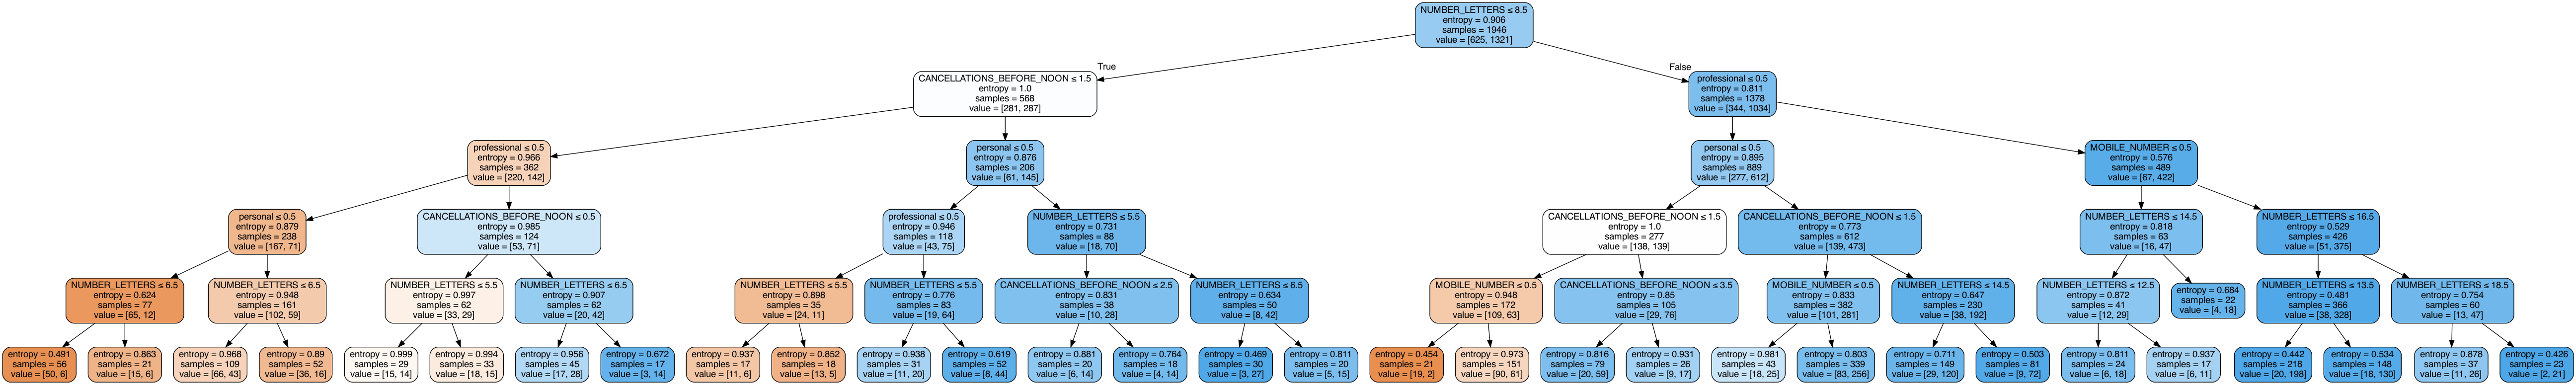

In [40]:
display_tree(tree = tree_tuned,
             feature_df = chef_data,
             height = 1500,
             width  = 1500)